# Ensembles de Modelos

Hoje vamos aprender uma das técnicas mais utilizadas em Machine Learning moderno: os ensembles



## Intuição ao Ensemble Learning

**Múltiplos weak learners juntos podem modelar comportamentos mais complexos.**

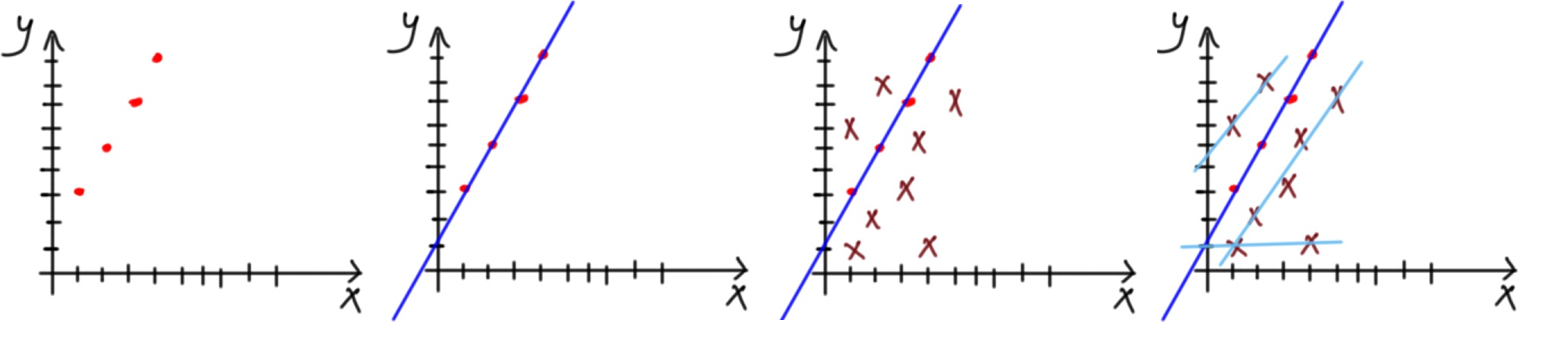

In [174]:
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, precision_recall_curve, auc, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## Lendo e Tratando os dados




In [236]:
df = pd.read_csv('tabular_playground_aug_22_train.csv')

In [ ]:
df.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [ ]:
df.isna().mean()

id                0.000000
product_code      0.000000
loading           0.009409
attribute_0       0.000000
attribute_1       0.000000
attribute_2       0.000000
attribute_3       0.000000
measurement_0     0.000000
measurement_1     0.000000
measurement_2     0.000000
measurement_3     0.014339
measurement_4     0.020248
measurement_5     0.025442
measurement_6     0.029959
measurement_7     0.035265
measurement_8     0.039443
measurement_9     0.046180
measurement_10    0.048927
measurement_11    0.055250
measurement_12    0.060256
measurement_13    0.066767
measurement_14    0.070531
measurement_15    0.075612
measurement_16    0.079413
measurement_17    0.085962
failure           0.000000
dtype: float64

In [ ]:
df['failure'].mean()

0.21260820474219044

#### Criando um pipeline de pre-processamento

In [ ]:
!pip install -q category-encoders

     |████████████████████████████████| 69 kB 1.5 MB/s 


In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [237]:
df.drop(columns = ['id'], inplace = True)

In [238]:
y = df.pop('failure')
X = df

cat_cols = ['product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3',]
one_hot_cols = [x for x in cat_cols if df[x].nunique() <= 3]
encoding_cols = list(set(cat_cols) - set(one_hot_cols))
numerical_cols = list(set(X.columns) - set(cat_cols))

In [ ]:
def print_score(cv_score):
    print(f"Average Score {cv_score['test_score'].mean():.2%} with standard deviation {cv_score['test_score'].std():.2%}")

In [166]:
def build_model_pipeline(model, scaling = False):
  numerical_steps = [('imputer', SimpleImputer())]
  if scaling:
    numerical_steps = numerical_steps + [('scaler', StandardScaler())]

  preprocessor = ColumnTransformer(
                          transformers=[
                              ('cat', Pipeline([('encoding_onehot', ce.OneHotEncoder(cols = one_hot_cols)),
                                                ('encoding', ce.WOEEncoder(cols = encoding_cols))]), cat_cols),
                              ('numerical', Pipeline(numerical_steps), numerical_cols),
                              ]
                          )
  return Pipeline([('preprocessor', preprocessor), ('model', model)])

## Primeiramente vamos treinar uma única Árvore de Decisão

In [167]:
from sklearn.tree import DecisionTreeClassifier

m_tree = build_model_pipeline(DecisionTreeClassifier(max_depth = 8))
cv_score = cross_validate(m_tree, X, y, cv = 5, scoring = 'roc_auc')
print_score(cv_score)

Average Score 52.85% with standard deviation 2.87%


### Voting 

In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [168]:
model1 = build_model_pipeline(LogisticRegression(), scaling = True)
model2 = build_model_pipeline(DecisionTreeClassifier(max_depth = 8))
model = VotingClassifier(estimators=[('lr', model1), ('dt', model2)], voting='soft')
cv_score = cross_validate(model, X, y, cv = 5, scoring = 'roc_auc')
print_score(cv_score)

Average Score 57.46% with standard deviation 2.71%


### Averaging

In [160]:
from sklearn.neighbors import KNeighborsClassifier

In [169]:
model1 = build_model_pipeline(DecisionTreeClassifier())
model2 = build_model_pipeline(KNeighborsClassifier(), scaling = True)
model3 = build_model_pipeline(LogisticRegression(), scaling = True)

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

acc = []

for id_train, id_test in kf.split(X):
  X_train = X.iloc[id_train, :]
  y_train = y[id_train]
  X_test =  X.iloc[id_test, :]
  y_test = y[id_test]

  model1.fit(X_train,y_train)
  model2.fit(X_train,y_train)
  model3.fit(X_train,y_train)

  pred1=model1.predict_proba(X_test)
  pred2=model2.predict_proba(X_test)
  pred3=model3.predict_proba(X_test)

  finalpred=(pred1*0.3+pred2*0.3+pred3*0.4)
  fpr, tpr, ts_roc = roc_curve(y_test, finalpred[:, 1])

  acc.append(auc(fpr, tpr))

print(f"Average Score {np.mean(acc):.2%} with standard deviation {np.std(acc):.2%}")

Average Score 53.45% with standard deviation 0.87%


## Boosting x Bagging


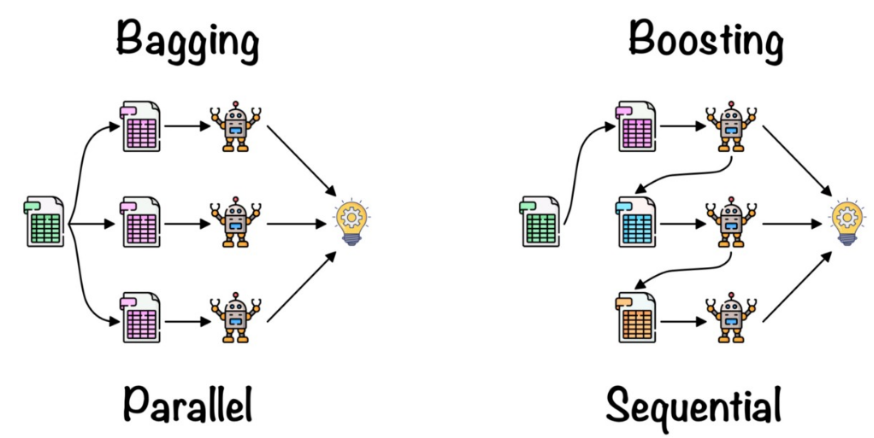

## Bagging

https://mlu-explain.github.io/random-forest/




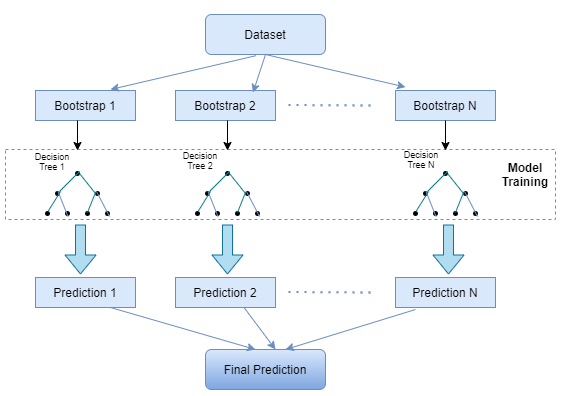

In [170]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = build_model_pipeline(BaggingClassifier(tree.DecisionTreeClassifier(random_state=1)))
cv_score = cross_validate(model, X, y, cv = 5, scoring = 'roc_auc')
print_score(cv_score)

Average Score 49.76% with standard deviation 3.10%


In [171]:
from sklearn.ensemble import RandomForestClassifier
model = build_model_pipeline(RandomForestClassifier())
cv_score = cross_validate(model, X, y, cv = 5, scoring = 'roc_auc')
print_score(cv_score)

Average Score 51.09% with standard deviation 3.88%


## Boosting

Nos algoritmos de boosting, a cada iteração são calculados erros 

**Adaboost**

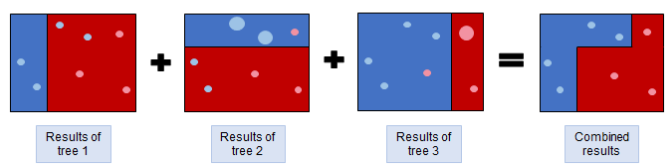

**Gradient Boosting Trees** como XGboost, LightGBM e Catboost têm se tornado os modelos de maior sucesso com dados tabulares

In [172]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(random_state=1)
model = build_model_pipeline(AdaBoostClassifier())
cv_score = cross_validate(model, X, y, cv = 5, scoring = 'roc_auc')
print_score(cv_score)

Average Score 57.89% with standard deviation 1.22%


In [173]:
import xgboost as xgb
model = build_model_pipeline(xgb.XGBClassifier(random_state=1, learning_rate=0.01))
cv_score = cross_validate(model, X, y, cv = 5, scoring = 'roc_auc')
print_score(cv_score)

Average Score 52.07% with standard deviation 6.10%


## Stacking

* Os modelos geralmente são diferentes

* Meta-learning 
* Outputs de modelos como input de outros

### One-level

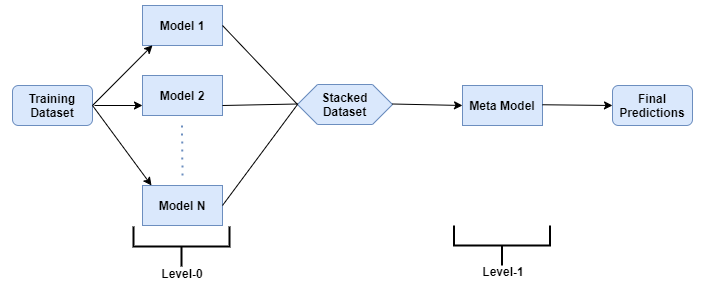

### Multi-level
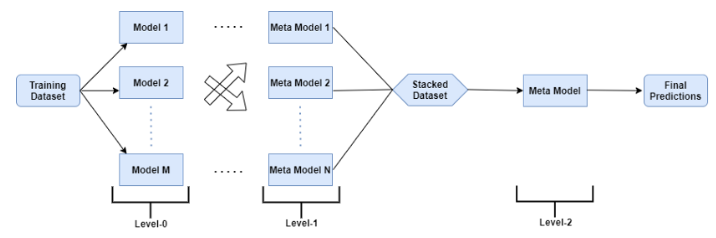

### Um exemplo de Stacking simples

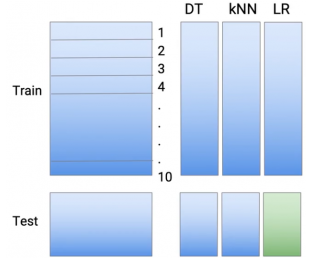

### MLEns

In [ ]:
!pip install -q mlens

     |████████████████████████████████| 227 kB 2.0 MB/s 


In [266]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from mlens.ensemble import SuperLearner
 
def build_preprocessing(scaling = False):
	numerical_steps = [('imputer', SimpleImputer())]
	if scaling:
		numerical_steps = numerical_steps + [('scaler', StandardScaler())]

	preprocessor = ColumnTransformer(
													transformers=[
															('cat', Pipeline([('encoding_onehot', ce.OneHotEncoder(cols = one_hot_cols)),
																								('encoding', ce.WOEEncoder(cols = encoding_cols))]), cat_cols),
															('numerical', Pipeline(numerical_steps), numerical_cols),
															]
													)
	return preprocessor

def get_models():
	models = list()
	models.append(LogisticRegression(solver='liblinear'))
	models.append(DecisionTreeClassifier())
	models.append(GaussianNB())
	models.append(KNeighborsClassifier())
	models.append(AdaBoostClassifier())
	models.append(BaggingClassifier())
	models.append(RandomForestClassifier())
	models.append(ExtraTreesClassifier())
	models.append(xgb.XGBClassifier())
	return models
 
def get_super_learner(X):
	ensemble = SuperLearner(scorer=roc_auc_score, folds=10, sample_size=len(X))
	preprocessing = build_preprocessing(scaling = True)
	models = get_models()
	ensemble.add(models, preprocessing = [preprocessing], proba = True)
	ensemble.add_meta(RandomForestClassifier())
	return ensemble

# model = build_model_pipeline(get_super_learner(X))

metrics = []
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
for id_train, id_test in kf.split(X):
	X_train = X.iloc[id_train, :]
	y_train = y[id_train]
	X_test =  X.iloc[id_test, :]
	y_test = y[id_test]
	slearner = get_super_learner(X_train)
	metrics.append(roc_auc_score(slearner.fit(X_train, y_train).predict_proba(X_test), y_test))

print(f"Average Score {np.mean(metrics):.2%} with standard deviation {np.std(metrics):.2%}")

Average Score 56.06% with standard deviation 1.91%


## TO DOs para melhorar performance: 
* Melhorar estratégia de imputing the missing values (por exemplo, analisando por product_code)
* Feature Engineering
* Tuning de hiperparâmetros dos modelos
* Superlearner com mais layers e propagation de features